<h1> Cours de Programation Parallel</h1> 
prof. Maketa Lutete Thomas 

## Plan du cours
1. Introduction Programation Parallèle en Python
2. Programation parallèle distribué avec Céléry
4. Programation parallèle en milieu virtualisé avec docker et kubernetes
5. Examen travail en groupe à présenter: Developer une application parallèle en utilisant docker, kubernetes, et python



## Documentation
- https://realpython.com/intro-to-python-threading/
- https://realpython.com/python-concurrency/
- https://www.geeksforgeeks.org/multiprocessing-python-set-1/
- https://fr.wikipedia.org/wiki/Parall%C3%A9lisme_(informatique)
- https://docs.python.org/3/library/multiprocessing.html

# 0. Introduction

La programmation parallèle (PP) a pour but de permettre a des programmes informatique d'effectuer plusieurs processus de calculs en parallèle.
La pp peut s'effectuer a plusieurs niveaux:
<ol> Microprocesseurs: microprocesseurs multimulticœurs augmenter la capacité de calcul par l'ajout des coeurs vu qu'il est difficile d'augmenter la fréquence des processeurs.
</ol>
<ol>Programme informatique: Programme capable d'exploiter les capacités multicœurs et simuler les processus parallèles sur des ordinateurs n'ayant pas de processus mono-coeur. </ol>
<ol>réseaux d'ordinateurs (Grid/distributed computing) plusieurs ordinateurs travaillant en parallèle pour effectuer une même tâche: Big data, virtualisation</ol>

Dans ce cours nous nous focaliserons sur le parallélisme appliqué aux:
<ol> programs informatique </ol> 
<ol> et aux réseaux d'ordinateurs (grid-computing)</ol>

# 1. Problématique
Les programmes informatiques fonctionnent de manière sérielle: instruction par instruction. 

Mais un programme peut être décomposé en tâches, ou processus, qui pourraient s'exécuter en parallèle. 

Par example un programme devant lire plusieurs fichiers et faire la sommation de tous les mots qui sont à l'interieur, pourrait avoir un processus mère qui lancerait plusieurs processus filles pour chaque fichier à lire et le processus mère s'occupera de faire la sommation. 

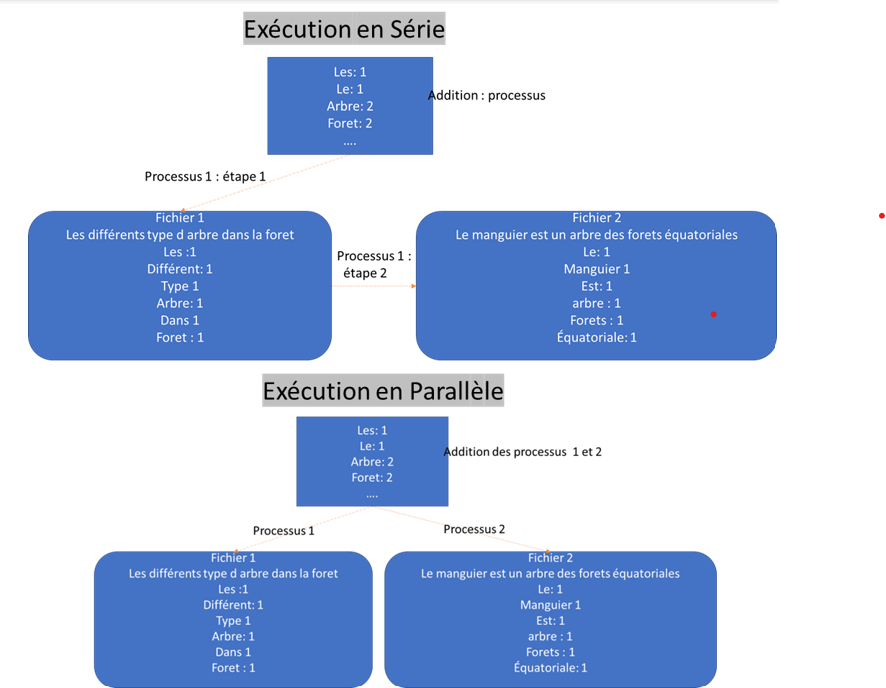

Example de parallélisation d'un programme

Dans cette introduction, nous allons utiliser la librairie python multiprocessing. Cette une des librairies python spécialisée dans le calcul parallèle, une introduction et une description de son usage sera donne plus loins dans le cour, mais a ce niveau ci, on voudrait juster donner un exemple rapide de programmation parallèle. Il ne faut pas trop s'attarder sur le code. A la fin de cette section, vous le comprendrez parfaitement. 

Tout d'abord regardons le nombre de processeurs installe dans mon ordinateur.

In [13]:
import multiprocessing as mp
print(f"Nombre de processeur(cpu): {mp.cpu_count()}")

Nombre de processeur(cpu): 8


Pour avoir une idée de la puissance du calcul parallel nous allons calculer le carré de 10 000 nombres générés aléatoirement de deux manière:
1. de manière sérielle
2. de manière parallèle

Nous commençons par créer une fonction qui sera utilisée par nos deux types de calcul, la fonction carré.

In [14]:
import numpy as np
import time

def carre(seed):
    np.random.seed(seed) #Initialise le générateur de nombres aléatoires.
    aleatoire_num = np.random.randint(0, 10) # Renvoie un entier aléatoire N tel que a <= N <= b. Alias pour randrange(a, b+1).
    return aleatoire_num**2 # Renvoie le nombre aléatoire au carré
    
t0 = time.time()
results = []
for i in range(10000000): 
    results.append(carre(i))
t1 = time.time()
print(f'temps d\'execution {t1 - t0} s')

temps d'execution 35.959041118621826 s


Faisons le même calcul en utilisant tous les coeurs de notre ordinateur.

In [15]:
t0 = time.time()
n_cpu = mp.cpu_count() # Nombre de de cpu

pool = mp.Pool(processes=n_cpu) # crée un pool pour chaque cpu
results = [pool.map(carre, range(10000000))] # execute la fonction carre 1000x et distribue le calcul sur tous les cpu
t1 = time.time()
print(f'Execution time {t1 - t0} s')

Execution time 12.80519723892212 s


En voyant les résultats, on pourrais se dire que tous les programmes devraient être parallélisés. Mais, tous les programmes ne bénéficient pas de la même manière de la parallélisation.


<h1>Efficacité de la parallélisation d'un programme</h1>

La loi d'Amdahl affirme que le gain apporté par la parallélisation d'un programme dépend de la partie du programme qui ne peut pas être parallélisé. 

https://fr.wikipedia.org/wiki/Loi_d%27Amdahl

Plus précisément elle donne l'accélération théorique en latence

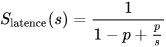

Slatence est l'accélération théorique en latence de l'exécution de toute la tâche ;

s est le nombre de fils d'exécutions (threads) utilisés pour exécuter la tâche

p est le pourcentage du temps d'exécution de toute la tâche concernant la partie bénéficiant de l'amélioration des ressources du système avant l'amélioration

Lorsque S le nombre de thread temps vers l'infini, l'accélération théorique est  égale 1/(1-p)

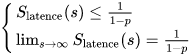

Certaines parties d'un programme ne peuvent être parallélisées, telles que des segments de codes gérant des itérations, ou des processus d'entré/sorti : lecture d'un fichier, lecture du disk dur, accès à la mémoire.
  


 Par exemple, si un programme a besoin de 20 heures d'exécution sur un processeur uni-cœur et que la partie non parallélisable requiert 1  heure d'exécution. Le programme parallélisé ne pourra pas être inférieur a 1 heure.
 
Dans ce cas la l'accélération théorique maximale que l'on peut espérer avec 19 heures d'exécution parallélisable sur 20 heures total est de:

1. Calculons p = 19/20 ce qui donne p = 0.95 .
2. Slat = 1/(1-p) = 1/(1-.95) = 20 %
 
 Ainsi, quel que soit le nombre de processeurs utilisés pour l'exécution parallèle du programme, l'accélération théorique maximale est limitée à au plus 20 %.

Exemple 2: une tâche demande 10 minutes à un seul processeur. Supposons ici que 3 minutes de cette tâche ne peuvent pas être exécutées en parallèle. Il reste 7 minutes qui peuvent être exécuter en parallèle. Première conséquence : quelque soit le nombre de processeurs rajouté, le temps total ne pourra pas être inférieur à ces 3 minutes.

Calculon son accélération maximale:
1. p = 7/10 = 0.7
2. Slat = 1/(1-.7) = 3.3

Ainsi l'amélioration théorique maximale est de 3 %

discussion intéressante sur la loi d'Amdhal : https://touilleur-express.fr/2021/01/11/amdahls-gunthers-laws-pour-lorganisation-des-equipes-de-developpement/

La loi de Gustafson elle stipule que la parallélisation d'un programme permet d'augmenter la quantité de données sur lesquelles des calculs sont effectués.

Ainsi en un temps égal la loi d'Amdahl donne le gain de vitesse maximale qu'un programme peut atteindre tandis que la loi de Gustafson donne la quantité de données supplémentaire qu'un programme peut traiter.

Derriere ces lois il y aussi des problèmes liés a l'architecture des ordinateurs, les communications entre les processeurs, les mémoires, les entrés sortis, qui demandent des mécanismes de synchronisation entre eux et qui fonctionnent à des vitesses différentes.

 Théorie de la chaîne de vélo: tout système est limité par sa partie la plus lente. 
 
 Et souvent la partie la plus lente sont la transmission et la gestion des donnés. Les lois ci-dessus sont un exemple. 

Ainsi il faut bien réfléchir sur l’opportunité de paralléliser des parties d'un programme. 

<h1> Type de problème paralélisable </h1>

Certains problèmes difficilement parallélisable peuvent être décomposés en sous-problèmes exécutables par différents processus en utilisant la methode de diviser pour regner (divide and conquer).

Les algorithmes les plus difficilement parallélisables sont les algorithmes iteratifs et recursifs. 

Les calculs itératifs (méthode de Newton, problème des trois corps) et récursifs (suite de Fibonacci, parcours en profondeur des graphes) évaluent une valeur finale par itérations successives. Chaque itération n produit une valeur qui est utlisée comme entré de l'itération n+1. Les fonctions récursives sont un cas particulier des procéssus itératifs où, une fonction s'appelle elle même dans une boucle. A chaque itération n la fonction utilise comme entré les valeurs calculée a n-1. 

Stratégie à appliquer: Diviser pour régner 

<ol>Diviser : découper un problème initial en sous-problèmes </ol>
<ol>Régner : résoudre les sous-problèmes (récursivement ou directement s'ils sont assez petits)</ol>
<ol>Combiner : calculer une solution au problème initial à partir des solutions des sous-problèmes. </ol> (Wikipedia)


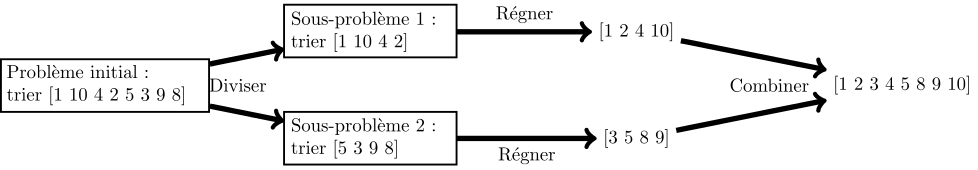

Par Fschwarzentruber — Travail personnel, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=47869242

Dépendance des données

Les calculs récursifs et itératifs sont des exemples de calculs où une étape de calcul dépend du résultat d'une étape préalable. Ce genre de calcul doit être exécuté séquentiellement. 

Définissons la notion de tâche indépendante: Une tâche indépendante est un calcul ou une action, ou une suite de calculs/actions, qui ensemblent aboutissent à un résultat. 

Par example une tache consiste à faire la sommation de tous les mots d'un fichier. Cette tâche est constituée de plusieurs action: localiser le fichier, ouvrir le fichier, lire chaque ligne du fichier, compter chaque mot du fichier, faire les sommations de tous les mots. La suite logique de ces action constituent la tâche indépendante pour la sommation de tous les mots d'un fichier.  

Dans une tâche indépendantes, certains calculs peuvent être parallélisable si ils répondent aux conditions de Bernstein permettant. 

Soit Pi et Pj deux fragments de code de programme. 
- Ii les variables d'entrées et Oi les variables de sorties de Pi
- Ij les variables d'entrées et Oj les variables de sorties de Pj

Pi et Pj sont indépendants s'ils satisfont les conditions suivantes :

(1)Oi ne dependent pas de Ii
Les outputs de Pi ne dependent pas des inputs de Pi
Pi n est pas récursif, et ses sorties ne dependent pas de ses entrés 
Indépendance des flux, le premier fragment produit des résultat qui ne sont pas utilisé par le second. 

(2)Ii intersection Oj = null
Les entrés de Pi ne dependent pas des sorties de Pj
Condition d'« antidépendance », le premier fragment écrase (c.-à-d. remplace) une variable utilisée par le second. 

(3)Oi intersection Oj  = null
Les sorties de Pi ne dependent pas des sorties de Pj
Condition sur les sorties, lorsque les deux fragments écrivent une même donnée, la valeur finale est celle produite par le fragment exécuté en dernier9.

Exemple les fonctions suivantes, qui démontrent plusieurs sortes de dépendances :

<ol>1: function Dep(a, b)</ol>
<ol>2: c := a·b</ol>
<ol>3: d := 2·c</ol>
<ol>4: end function</ol>

L'opération 3 dans Dep (a, b) ne peut pas être exécutée avant (ni même en parallèle avec) l'opération 2, car l'opération 3 utilise un résultat d'exploitation 2. Il viole la condition 2, et introduit ainsi une dépendance de flux.

<ol>1: function NoDep(a, b)</ol>
<ol>2: c := a·b</ol>
<ol>3: d := 2·b</ol>
<ol>4: e := a+b</ol>
<ol>5: end function</ol>

Dans cet exemple, il n'y a pas de dépendances entre les instructions, de sorte qu'elles peuvent être exécutées en parallèle.

Les conditions de Bernstein ne permettent pas de gérer l'accès à la mémoire entre différents processus. Il faut utiliser des méthodes de synchronisation.

# 2. Programmation parallèle: exemple en Python  

Texte et Code inspiré par l'article de Nikhil Kumar : https://www.geeksforgeeks.org/synchronization-pooling-processes-python/ et la documentation de la librairie python multiprocessing : https://docs.python.org/3/library/multiprocessing.html

La programmation parallèle en python utilise des threads ou des process. Les deux sont utilisés pour lancer à partir d'un programme mère des processus fille qui s’exécutent en parallèle. Mais en réalité, pour la plupart des implémentations Python 3, les threads et les process ne s'exécutent pas réellement en même temps : ils semblent simplement le faire.

#### Thread (fil en français)
les thread peuvent être pensés comme deux (ou plus) tâches indépendantes s'exécutant en même temps dans un programme. Les threads peuvent s'exécuter sur différents processeurs.

En raison du fonctionnement de l'implémentation CPython de Python, le threading peut ne pas accélérer toutes les tâches. Cela est dû aux interactions avec le Global Interpreter Lock (GIL) qui limitent essentiellement l'exécution d'un thread Python à la fois.

Les tâches qui passent une grande partie de leur temps à attendre des événements externes sont généralement de bons candidats pour le threading. Les problèmes qui nécessitent des calculs CPU lourds et qui passent peu de temps à attendre des événements externes peuvent ne pas s'exécuter plus rapidement du tout.

Les threads partagent entre eux la mémoire, et ainsi les threads peuvent modifier les même variables dans un même programme. 

#### Process
 Version amélioré des threads, les process donnent un meilleur contrôle sur l’utilisation des processeurs multi-coeurs. Les process sont indépendant les uns des autres et ne partagent pas les variables entre elles. Pour partager les variables entre process il faut utiliser soit des manager de process, ou des queues.

Exemple d'un programme Python PP

In [43]:
# importer le module multiprocessing 
import multiprocessing

def print_cube(num):
	"""
	fonction imprimer le cube d'un nombre
	"""
	print("Cube: {}".format(num * num * num))

def print_carre(num):
	"""
	fonction imprimer le carré d'un nombre
	"""
	print("Square: {}".format(num * num))

if __name__ == "__main__":
	# creation processes
	p1 = multiprocessing.Process(target=print_carre, args=(10 ))
	p2 = multiprocessing.Process(target=print_cube, args=(10, ))

	# lancer process 1
	p1.start()
	# lancer process 2
	p2.start()

	# attendre la fin process 1
	p1.join()
	# attendre fin process 2 i
	p2.join()

	# les processes terminés
	print("Finit!")


Square: 100
Cube: 1000
Finit!


Pour créer un processus, nous créons un objet de la classe Process. 

Il prend les arguments suivants :
<ol>target (cible) : la fonction à exécuter par le processus</ol>
<ol>argument (args) : les arguments à passer à la fonction cible</ol>

Remarque : Le constructeur de processus prend également de nombreux autres arguments, il faut explorer la documentation pour les connaître tous. 

Dans l'exemple ci-dessus, nous avons créé 2 processus avec différentes fonctions cibles :
<ol>p1 = multiprocessing.Process(target=afficher _carre, args=(10, ))</ol>
<ol>p2 = multiprocessing.Process(target=afficher _cube, args=(10, ))</ol>

Pour démarrer un processus, nous utilisons la méthode start de la classe Process .
<ol>p1.start()</ol>
<ol>p2.start()</ol>

Une fois les processus démarrés, le programme en cours continue également à s'exécuter. Afin d'arrêter l'exécution du programme en cours jusqu'à ce qu'un processus soit terminé, nous utilisons la méthode join .
<ol>p1.join()</ol>
<ol>p2.join()</ol>

Ainsi, le programme en cours attend d'abord la fin de p1 puis de p2 . Une fois qu'ils sont terminées, les instructions suivantes du programme en cours sont exécutées.

Example 2

In [46]:
# importer the multiprocessing module
import multiprocessing
import os

def travailleur1():
	# imprimer process id
	print ("ID du processus ayant lancé travailleur1: {}".format(os.getpid()))

def travailleur2():
	# imprimer process id
	print("ID du processus ayant lancé travailleur2: {}".format(os.getpid()))

if __name__ == "__main__":
	# imprimer main program process id
	print("ID du processus main (process mère, process principal): {}".format(os.getpid()))

	# creation processesus
	p1 = multiprocessing.Process(target=travailleur1)
	p2 = multiprocessing.Process(target=travailleur2)

	# lancer processus
	p1.start()
	p2.start()

	# process IDs
	print("ID du processus p1: {}".format(p1.pid))
	print("ID du processus p2: {}".format(p2.pid))

	# attendre jusqu’à ce que les processes soient terminé
	p1.join()
	p2.join()

	# 2 processus terminé
	print("Les deux processus ont fini leur exécution!")

	# vérifier si processus sont actif
	print("Processus p1 is actif: {}".format(p1.is_alive()))
	print("Processus p2 is actif: {}".format(p2.is_alive()))


ID du processus main (process mère, process principal): 554021
ID du processus ayant lancé travailleur1: 574091
ID du processus ayant lancé travailleur2: 574094
ID du processus p1: 574091
ID du processus p2: 574094
Les deux processus ont fini leur exécution!
Processus p1 is actif: False
Processus p2 is actif: False


Le script python principal (processus main) a un ID de processus différent des processus filles p1 et p2 générés par le module multiprocessing. 

Dans le programme ci-dessus, la fonction os.getpid() nous permet d'obtenir l'ID du processus exécutant la fonction cible. Dans ce cas ci, pour le processus p1 la fonction cible est travailleur1 et pour le processus p2 la fonction cible est travailleur2.

Chaque processus s'exécute indépendamment et dispose de son propre espace mémoire.

Dès que l'exécution de la fonction cible est terminée, les processus se terminent. Dans le programme ci-dessus, nous avons utilisé la méthode is_alive de la classe Process pour vérifier si un processus est toujours actif ou non.

## 2.1 Partage de données et de transmission de messages entre processus 

### Modèle théorique de gestion des communication entre processus

#### Utilisation d'une mémoire partagée 
- L'échange d'information entre processus se fait par accès à des données à travers une zone mémoire partagée.
Le partage des zone mémoire peuvent créer le phénomène de course aux resources qui sera expliqué dans la section ci bas

#### Le modèle « producteur-consommateur » avec utilisation des queues
- Des processus dits « producteurs » produisent des données qui sont posés dans une file d'attente, ces données sont consommées par les processus dits « consommateurs »

#### Le modèle « lecteur/receveur - rédacteur/envoyer » avec utilisation des pipes (tuyaux, tubes)
- Ce focalise dans la gestion des flux, il y a un rédacteur qui génèrent des donnees a un debit connu et des lecteur qui se connectent a des flux d'un receveur et doit adapter son debit de reception a celui du receveur. La principale difficulté du programmeur est d'écrire des algorithmes qui produisent des débits comparables pour les uns et les autres.



### 2.1.1 Mémoire partagée

plusieurs modèles d`accès à la mémoire peuvent être utilisés pour des processus s'exécutant en parallèle :

1. Chaque processus a accès un segment de la mémoire a travers un cache. Lorsque le processus modifie une donnée dans ce cache, le système doit en fait la modifier dans l'espace commun et répercuter cette modification au sein de tous les caches où cette donnée est présente. Des mécanismes sont mis en place pour que les données restent cohérentes. 

2. Certaines ressources ne peuvent être disponibles en même temps que pour un nombre restreint de tâches. C'est typiquement le cas pour l'accès en écriture sur un fichier sur disque par exemple. Alors que celui-ci est disponible pour théoriquement un nombre infini en lecture seule, le fichier n'est disponible que pour une seule tâche en lecture-écriture, toute lecture par un autre processus est alors proscrite. 

3. Tous les processus ont accès a toute la mémoire en même temps. Les accès à ces variables se font d'une manière indépendante, et ces accès peuvent occasionner des erreurs et nécessitant des mécanismes de synchronisation des accès aux resources pour éviter les effets de compétitions.

Dans l'exemple suivant, nous essayons d'imprimer le contenu de la variable résultat contenant une liste à deux endroits :

Dans la fonction square_list en utilisant le mot cléf global et dans la fonction principal main. 



In [47]:
import multiprocessing as mp

# list vide stockée dans la variable résultat ayant une portée global
#cette variable est accessible a tout le programme
resultat = []

def liste_des_carre(mylist):
	"""
	fonction pour mettre au carré tous les éléments d'une liste
	"""
	global resultat  # utiliser la variable global résultat et ne pas créer une variable locale 
	# ajouter à la variable global resultat les élément de mylist après les avoir mis au carré
	for num in mylist:
		resultat.append(num * num)
	# Afficher la variable global resultat à partir de la fonction liste des carrés
	print("variable resultat (dans le processus p1): {}".format(resultat))

if __name__ == "__main__":
	# input list
	mylist = [1,2,3,4]

	# creation d'un processus qui a pour cible la fonction liste des carré et argument mylist
	p1 =    mp.Process(target=liste_des_carre, args=(mylist,))
	# lancer le processus
	p1.start()
	# attendre jusqu'â ce que le processus se termine
	p1.join()

	# Afficher la variable global resultat à partir de la fonction main
	print("variable resultat (dans le processus principal main): {}".format(resultat))


variable resultat (dans le processus p1): [1, 4, 9, 16]
variable resultat (dans le processus principal main): []


Mais nous remarquons que la variable "resultat" que nous avons pensé modifier dans le processus p1 ne l'est pas dans le processus principal main.La variable "resultat" dans main contient toujours la liste de résultats vide et la variable "resultat" dans p1 contient les éléments de la liste mis au carrés.

Ceci est du au fait que les processus ne partagent pas les même espaces mémoire. Les variables globales ne sont pas partagées entre les procéessus.  

Pour partager des variables entre processus on utilise les objets array et value du module multiprocessing ou les managers, qui sont expliqués dans les sections suivantes.

#### Mémoire partagée dans le module multiprocessing 
Le module de multitraitement fournit les objets Array et Value pour partager des données entre processus.
- Array : un tableau ctypes alloué à partir de la mémoire partagée .
- Valeur : un objet ctypes alloué à partir de la mémoire partagée .

In [48]:
from multiprocessing import Process, Value, Array

def f(n, a):
    # fonction qui modifie les variables n et a dans le processus f
    n.value = 3.1415927
    for i in range(len(a)):
        a[i] = -a[i]

if __name__ == '__main__':
    #définition d'une variable multiprocessing.Value de type décimal
    num = Value('d', 0.0)
    #définition d'une variable multiprocessing.array (tableau) de type entier
    arr = Array('i', range(10))
    # création du processus p qui cible la fonction f et qui prend comme argument les 2 variables num et arr
    p = Process(target=f, args=(num, arr))
    # lancement du processus p
    p.start()
    # attente que le processus p se termine
    p.join()

    # afficher la valeur de la variable num
    print("variable num (dans le processus principal main): {}".format(num.value))
    # afficher la valuer du vecteur arr
    print("variable arr (dans le processus principal main): {}".format(arr[:]))
    

variable num (dans le processus principal main): 3.1415927
variable arr (dans le processus principal main): [0, -1, -2, -3, -4, -5, -6, -7, -8, -9]


Les arguments 'd' et 'i' utilisés à la création des num et arr sont des codes de types identiques à ceux du module array : 'd' indique un flottant double-précision et 'i' indique un entier signé. Ces objets peuvent être partagés sans problème entre processus ou fils d’exécution.

Pour plus de flexibilité dans l'utilisation de mémoire partagée, vous pouvez utiliser le module multiprocessing.sharedctypes qui permet la création d'objets arbitraires ctypes alloués depuis la mémoire partagée.

example 2

In [49]:
import multiprocessing

def liste_des_carre(mylist, resultat, somme_des_carre):
	"""
	fonction pour mettre au carré les élements d'une liste
	"""
	# ajouter les carrés de a la variable résultat
	for idx, num in enumerate(mylist):
		resultat[idx] = num * num

	# Somme des carrés
	somme_des_carre.value = sum(resultat)

	# afficher le vecteur Array
	print("Résultat (dans process p1): {}".format(resultat[:]))

	# afficher la somme des carrés 
	print("Somme des carrés (dans process p1): {}".format(somme_des_carre.value))

if __name__ == "__main__":
	# liste d'entré
	mylist = [1,2,3,4]

	# création du vecteur d'entiers à 4 éléments
	resultat = multiprocessing.Array('i', 4)

	# créatinon de la variable de type entier
	somme_des_carre = multiprocessing.Value('i')

	#  création du procesus p1
	p1 = multiprocessing.Process(target=liste_des_carre, args=(mylist, resultat, somme_des_carre))

	# lancement du procesus p1
	p1.start()

	# attendre jusqu’à ce que the process se termine
	p1.join()

	# afficher la variable vecteur 
	print("Résultat (dans process main): {}".format(resultat[:]))

	# afficher la variable somme des carrés 
	print("Somme des carrés (dans process main): {}".format(somme_des_carre.value))


Résultat (dans process p1): [1, 4, 9, 16]
Somme des carrés (dans process p1): 30
Résultat (dans process main): [1, 4, 9, 16]
Somme des carrés (dans process main): 30


Essayons de comprendre le code ci-dessus ligne par ligne :

Tout d'abord, nous créons un résultat Array comme celui-ci :
  result = multiprocessing.Array('i', 4)

Le premier argument est le type de données . 'i' signifie entier alors que 'd' signifie type de données flottant.

Le deuxième argument est la taille du tableau. Ici, nous créons un tableau de 4 éléments.
De même, nous créons une Value square_sum comme ceci :

  square_sum = multiprocessing.Value('i')

Ici, nous avons seulement besoin de spécifier le type de données. La valeur peut recevoir une valeur initiale (disons 10) comme ceci :

  square_sum = multiprocessing.Value('i', 10)

Deuxièmement, nous passons result et square_sum comme arguments lors de la création de l'objet Process .
  p1 = multiprocessing.Process(target=square_list, args=(mylist, result, square_sum))

Les éléments du tableau de résultat reçoivent une valeur en spécifiant l'index de l'élément du tableau.
  for idx, num in enumerate(mylist):
      result[idx] = num * num
square_sum reçoit une valeur en utilisant son attribut value :

  square_sum.value = sum(result)
Afin d'imprimer les éléments du tableau de résultats , nous utilisons result[:] pour imprimer le tableau complet.
  print("Result(in process p1): {}".format(result[:]))
La valeur de square_sum est simplement imprimée comme suit :

  print("Sum of squares(in process p1): {}".format(square_sum.value))

#### Mémoire partagée Processus serveur et Manager

chaque fois qu'un programme python démarre, un processus serveur est également lancé. À partir de là, chaque fois qu'un nouveau processus est nécessaire, le processus parent se connecte au serveur et lui demande de créer un nouveau processus.

Un objet gestionnaire renvoyé par Manager() contrôle un processus serveur qui détient les objets Python et autorise les autres processus à les manipuler à l'aide de mandataires.

Le module multitraitement fournit une classe Manager qui contrôle un processus serveur. Par conséquent, les gestionnaires fournissent un moyen de créer des données qui peuvent être partagées entre différents processus.

Un objet gestionnaire renvoyé par Manager() contrôle un processus serveur qui détient les objets Python et autorise les autres processus à les manipuler à l'aide de mandataires.

Un gestionnaire renvoyé par Manager() prend en charge les types list, dict, Namespace, Lock, RLock, Semaphore, BoundedSemaphore, Condition, Event, Barrier, Queue, Value et Array.

Les gestionnaires de processus serveur sont plus flexibles que l'utilisation d'objets de mémoire partagée car ils peuvent être conçus pour prendre en charge des types d'objets arbitraires tels que des listes, des dictionnaires, une file d'attente, une valeur, un tableau, etc. 

De plus, un seul gestionnaire peut être partagé par des processus sur différents ordinateurs sur un réseau. . Ils sont cependant plus lents que l'utilisation de la mémoire partagée.


Prenons l'exemple ci-dessous :

exemple 1

In [ ]:
from multiprocessing import Process, Manager

def f(d, l):
    d[1] = '1'
    d['2'] = 2
    d[0.25] = None
    l.reverse()

if __name__ == '__main__':
    with Manager() as manager:
        d = manager.dict()
        l = manager.list(range(10))

        p = Process(target=f, args=(d, l))
        p.start()
        p.join()

        print(d)
        print(l)

Exercisse expliquez le code ci dessus

Example 2

In [21]:
import multiprocessing

def print_records(records):
	"""
	fonction pour afficher record(tuples) dans records(list)
	"""
	for record in records:
		print("Nom: {0}\nScore: {1}\n".format(record[0], record[1]))

def insert_record(record, records):
	"""
	fonction pour ajouter un nouvel élément dans records(list)
	"""
	records.append(record)
	print("Nouvel élément ajouté!\n")

if __name__ == '__main__':
	with multiprocessing.Manager() as manager:
		# creation de la list dans le server process memory
		records = manager.list([('Sam', 10), ('Adam', 9), ('Kevin',9)])
		# nouvel élément devant être inséré dans la variable records
		new_record = ('Jeff', 8)

		# creation processus p1 et p2
		p1 = multiprocessing.Process(target=insert_record, args=(new_record, records))
		p2 = multiprocessing.Process(target=print_records, args=(records,))

		# lancement processus p1 pour inserer nouvel élément 
		p1.start()
		p1.join()

		# lancement processus p2 pour afficher records
		p2.start()
		p2.join()


Nouvel élément ajouté!

Nom: Sam
Score: 10

Nom: Adam
Score: 9

Nom: Kevin
Score: 9

Nom: Jeff
Score: 8



Essayons de comprendre le morceau de code ci-dessus :

Tout d'abord, nous créons un objet gestionnaire en utilisant :
  with multiprocessing.Manager() as manager:
Toutes les lignes sous with bloc d'instructions sont sous la portée de l'objet gestionnaire .

Ensuite, nous créons une liste d'enregistrements dans la mémoire du processus du serveur en utilisant :
  records = manager.list([('Sam', 10), ('Adam', 9), ('Kevin',9)])
De même, vous pouvez créer un dictionnaire en tant que méthode manager.dict .

Enfin, nous créons les processus p1 (pour insérer un nouvel enregistrement dans la liste des enregistrements ) et p2 (pour imprimer des enregistrements ) et les exécutons en passant des enregistrements comme l'un des arguments.

#### La synchronisation des accès a la mémoire : Section critique

Lorsque des processus partagent des variables entre-elles, il faut éviter que deux processus concurrents ou plus exécutent simultanément un segment de leur programme sur une meme variable (zone mémoire).

La section critique fait référence aux parties du programme où la ressource partagée est accessible.

Par exemple, dans le diagramme ci-dessous, 3 processus tentent d'accéder à une ressource partagée ou à une section critique en même temps.

image .....

Des accès simultanés à des ressources partagées peuvent conduire à des conditions de concurrence .

Une condition de concurrence se produit lorsque deux processus ou plus peuvent accéder à des données partagées et tentent de les modifier en même temps. Par conséquent, les valeurs des variables peuvent être imprévisibles et varier en fonction des horaires des changements de contexte des processus.

Exemple 1 de condition de concurrence
Processus  A	                            Processus B	
1A: Lire variable V	                    1B: Lire variable V
2A: Add 1 à la variable V	            2B: Add 1 à la variable V
3A: Écrire la variable V	            3B: Écrire la variable V

Le résultat de l'exécution des processus ci dessus n'est pas prévisible. Les processus A et B s'exécutent, de manière indépendante et imprévisible cela dépend en effet de la manière dont les exécutions se chevauchent. 
Dans l'hypothèse la plus simple ou les processus A et B s'exécutent une fois, l'ordre d'exécution des instructions peut être par exemple : Lire, Lire, Add, Add, Écrire, Écrire ou bien Lire, Add, Écrire, Lire, Add, Écrire. 
Le résultat dans ces deux hypothèses n'est pas le même puisqu'au final dans le second cas la variable est augmentée de deux alors qu'elle n'est augmentée que de un dans le premier. Ce phénomène est connu sous le nom de situation de compétition.

Example  Considérons le programme ci-dessous pour comprendre le concept de condition de concurrence :

In [24]:
import multiprocessing

# fonction pour déduire d'un compte
def withdraw(balance):	
	for _ in range(10000):
		balance.value = balance.value - 1

# fonction pour ajouter à un compte
def deposit(balance):	
	for _ in range(10000):
		balance.value = balance.value + 1

def perform_transactions():

	# initial balance (in shared memory)
	balance = multiprocessing.Value('i', 100)

	# creation nouveau processus
	p1 = multiprocessing.Process(target=withdraw, args=(balance,))
	p2 = multiprocessing.Process(target=deposit, args=(balance,))

	# lancer processes
	p1.start()
	p2.start()

	# attendre jusqu’à ce que processes se termine
	p1.join()
	p2.join()

	# afficher final balance
	print("Final balance = {}".format(balance.value))

if __name__ == "__main__":
	for _ in range(10):

		# perform same transaction process 10 times
		perform_transactions()


Final balance = 100
Final balance = 87
Final balance = -5
Final balance = 929


Final balance = 435
Final balance = 78
Final balance = -542
Final balance = -163
Final balance = 229
Final balance = -36


Dans le programme ci-dessus, 10 000 transactions de retrait et 10 000 transactions de dépôt sont effectuées avec un solde initial de 100. Le solde final attendu est de 100, mais ce que nous obtenons en 10 itérations de la fonction perform_transactions correspond à des valeurs différentes.

Cela se produit en raison de l'accès simultané et de manière aléatoire des processus à la resources mémoire qui est partagée. Cette imprévisibilité de la valeur de la mémoire partagée est rien d'autre qu'une condition de course (race condition).



### Utilisation des verrous (Lock)

Pour résoudre ce genre de problème on utilise un verrou d'exclusion mutuelle.

La classe Lock gère les conditions de concurrence. Lock est implémenté à l'aide d'un objet Semaphore fourni par le système d'exploitation.

Un sémaphore est un objet de synchronisation qui contrôle l'accès de plusieurs processus à une ressource commune. Il s'agit simplement d'une valeur à un endroit désigné dans le stockage du système d'exploitation (ou du noyau) que chaque processus peut vérifier puis modifier. Selon la valeur trouvée, le processus peut utiliser la ressource ou constater qu'elle est déjà utilisée et doit attendre un certain temps avant de réessayer. Les sémaphores peuvent être binaires (0 ou 1) ou peuvent avoir des valeurs supplémentaires. En règle générale, un processus utilisant des sémaphores vérifie la valeur, puis, s'il utilise la ressource, modifie la valeur pour refléter cela afin que les utilisateurs de sémaphores suivants sachent qu'ils doivent attendre.

Un exemple d'utilisation des verrous pour acceder a une section critiques est donee ci bas, mais ce genre de mécanismes est source potentielle de bug informatique.	
<br>

Thread A	                                    Thread B
<br>
1A: Verrouiller la variable V	                1B: Verrouiller la variable V
<br>
2A: Lire la variable V	                        2B: Lire la variable V
<br>
3A: Add 1 à la variable V	                    3B: Add 1 à la variable V
<br>
4A: Écrire la variable V	                    4B: Écrire la variable V
<br>
5A: déverrouiller la variable V	                5B: déverrouiller la variable V

Une forte utilisation des verrous augmente le risque de bugs, il est recommandé de les minimiser.  Si la première tâche verrouille la première variable pendant que la seconde tâche verrouille la seconde, alors les deux tâches seront mises en sommeil. Il s'agit là d'un cas d'interblocage, autrement appelé d'« étreinte mortelle » ou « étreinte fatale ».

Certaines méthodes de programmation, dites non bloquantes, cherchent à éviter d'utiliser ces verrous. Elles utilisent elles-mêmes des instructions atomiques. La mémoire transactionnelle logicielle en est une.

example 1 verous

In [ ]:
from multiprocessing import Process, Lock

def f( i):
    print('hello world', i,'\n')
    
if __name__ == '__main__':
    
    for num in range(10):
        Process(target=f, args=(num,)).start()

hello world 0 



hello world 1 

hello world 2 

hello world 3 

hello world 4 

hello world 5 

hello world 6 

hello world 7 

hello world 8 

hello world 9 



mem code avec verrou

In [ ]:
from multiprocessing import Process, Lock

def f(l, i):
    l.acquire()
    try:
        print('hello world', i,'\n')
    finally:
        l.release()

if __name__ == '__main__':
    lock = Lock()

    for num in range(10):
        Process(target=f, args=(lock, num)).start()

hello world 0 

hello world 1 

hello world 2 

hello world 3 

hello world 4 

hello world 5 

hello world 6 

hello world 7 

hello world 8 

hello world 9 



Expliquons le code ci dessus ......................
verrou pour s'assurer qu'un seul processus à la fois écrit sur la sortie standard :
Sans le verrou, les sorties des différents processus risquent d'être mélangées.



example 2 utilisation de verrou

In [20]:
import multiprocessing

# function to withdraw from account
def withdraw(balance, lock):	
	for _ in range(10000):
		lock.acquire()
		balance.value = balance.value - 1
		lock.release()

# function to deposit to account
def deposit(balance, lock):	
	for _ in range(10000):
		lock.acquire()
		balance.value = balance.value + 1
		lock.release()

def perform_transactions():

	# initial balance (in shared memory)
	balance = multiprocessing.Value('i', 100)

	# creating a lock object
	lock = multiprocessing.Lock()

	# creating new processes
	p1 = multiprocessing.Process(target=withdraw, args=(balance,lock))
	p2 = multiprocessing.Process(target=deposit, args=(balance,lock))

	# lancer processes
	p1.start()
	p2.start()

	# attendre jusqu'â ce que processes are finished
	p1.join()
	p2.join()

	# print final balance
	print("Final balance = {}".format(balance.value))

if __name__ == "__main__":
	for _ in range(10):

		# perform same transaction process 10 times
		perform_transactions()

Final balance = 100
Final balance = 100
Final balance = 100


Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100


Essayons de comprendre le code ci-dessus étape par étape :

Tout d'abord, un objet Lock est créé en utilisant :

verrou = multiprocessing.Lock()

Ensuite, lock est passé comme argument de la fonction cible :

p1 = multiprocessing.Process(target=retirer, args=(balance,lock))

p2 = multiprocessing.Process(target=deposit, args=(balance,lock))

Dans la section critique de la fonction cible, nous appliquons le verrouillage à l'aide de la méthode lock.acquire() . 

Dès qu'un verrou est acquis, aucun autre processus ne peut accéder à sa section critique tant que le verrou n'est pas libéré à l'aide de la méthode lock.release() .

verrouiller.acquérir()
solde.valeur = solde.valeur - 1
verrouiller.libérer()

Dans les résultats on peut voir que le solde final est de 100 à chaque fois (ce qui est le résultat final attendu).

Efficacité et limites des verrous

Plus le nombre de tâches est élevé dans un programme, plus ce programme passe son temps à effectuer des verrouillages et plus il passe son temps à échanger des messages entre tâches. 

Lorsque le nombre de tâches augmente trop, la programmation concourante ne permet plus d'augmenter la vitesse d'exécution du programme, car le programme passe son temps à mettre en sommeil les tâches qui le composent et à écrire des informations qui permettent l'échange d'information entre tâches. Ce phénomène est appelé le ralentissement parallèle.

Les applications sont classées en fonction de la fréquence à laquelle leurs tâches dialoguent ou se synchronisent. 

Les applications ayant beaucoup d'échanges ou de synchronisations entre leurs sous-tâches sont dites fine-grained (à grain fin), celles qui ont au contraire peu d'échanges et de synchronisations sont dites coarse-grained c'est-à-dire à gros grain. 

L'algorithme est dit embarrassingly parallel, c'est-à-dire de « parallélisme embarrassant » s'il n'y a aucun contact entre les sous-tâches. Ce dernier est le plus simple à programmer en parllèle.

### 2.1.2 Les files d'attentes : Queue  

Quand plusieurs processus travaillent ensemble, il est souvent nécessaire de les faire communiquer entre eux pour éviter d'avoir à utiliser des primitives de synchronisation comme les verrous.



File d'attente : Un moyen simple de communiquer entre les processus consistant à utiliser une file d'attente pour faire passer des messages. Tout objet Python peut passer par une file d'attente.

Les types Queue, SimpleQueue et JoinableQueue sont des files FIFO multi-producteurs et multi-consommateurs modelées sur la classe queue.Queue de la bibliothèque standard. Elles diffèrent par l'absence dans Queue des méthodes task_done() et join() introduites dans la classe queue.Queue par Python 2.5.

Si vous utilisez JoinableQueue alors vous devez appeler JoinableQueue.task_done() pour chaque tâche retirée de la file, sans quoi le sémaphore utilisé pour compter le nombre de tâches non accomplies pourra éventuellement déborder, levant une exception.

Notez que vous pouvez aussi créer une file partagée en utilisant un objet gestionnaire – voir Gestionnaires.

exemple 


In [28]:
from multiprocessing import Process, Queue

def f(q):
    q.put([1,2,3, None, 'hello']) # mettre la liste dans la queue

if __name__ == '__main__':
    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    e=q.get()
    print(e)    # imprime la queue "[1,2,3, None, 'hello']"
    p.join()

[1, 2, 3, None, 'hello']


exemple 2

In [30]:
import multiprocessing

def square_list(mylist, q):
	"""
	function to square a given list
	"""
	# append squares of mylist to queue
	for num in mylist:
		q.put(num * num)

def print_queue(q):
	"""
	function to print queue elements
	"""
	print("Queue élements:")
	while not q.empty():
		print(q.get())
	print("Queue est vide!")

if __name__ == "__main__":
	# input list
	mylist = [1,2,3,4]

	# creating multiprocessing Queue
	q = multiprocessing.Queue()

	# creating new processes
	p1 = multiprocessing.Process(target=square_list, args=(mylist, q))
	p2 = multiprocessing.Process(target=print_queue, args=(q,))

	# running process p1 to square list
	p1.start()
	p1.join()

	# running process p2 to get queue elements
	p2.start()
	p2.join()


Queue élements:
1
4
9
16
Queue est vide!


Essayons de comprendre le code ci-dessus étape par étape :

Tout d'abord, nous créons une file d'attente multitraitement en utilisant :
  q = multiprocessing.Queue()
Ensuite, nous passons la file d'attente vide q à la fonction square_list via le processus p1 . Les éléments sont insérés dans la file d'attente à l'aide de la méthode put .
  q.put(num * num)
Pour imprimer les éléments de la file d'attente, nous utilisons la méthode get jusqu'à ce que la file d'attente ne soit pas vide.
  while not q.empty():
      print(q.get())
Vous trouverez ci-dessous un schéma simple illustrant les opérations en file d'attente :

### 2.1.3 Pipes : Canal bi-directionnelle de communication

Une pipe ne peut avoir que deux extrémités. Par conséquent, il est préférable à la file d'attente lorsque seule une communication bidirectionnelle est requise.
La fonction Pipe renvoie une paire d'objets de connexion connectés par un tuyau. Les deux objets de connexion renvoyés par Pipe() représentent les deux extrémités du tuyau. Chaque objet de connexion a des méthodes send() et recv() (entre autres).

La fonction Pipe() renvoie une paire d'objets de connexion connectés à un tube qui est par défaut duplex (à double sens).

Auditeurs et Clients
Habituellement l'échange de messages entre processus est réalisé en utilisant des files ou des objets Connection renvoyés par Pipe().

Cependant, le module multiprocessing.connection permet un peu plus de flexibilité. Il fournit un message de plus haut-niveau orienté API pour gérer des connecteurs ou des tubes nommés sous Windows. Il gère aussi l'authentification par condensat (digest authentication en anglais) en utilisant le module hmac, et pour interroger de multiples connexions en même temps.

Example 1 

In [51]:
from multiprocessing import Process, Pipe

def f(conn):
    conn.send([1,2,3,None, 'hello'])
    conn.close()

if __name__ == '__main__':
    parent_conn, child_conn = Pipe()
    p = Process(target=f, args=(child_conn,))
    p.start()
    print(parent_conn.recv())   # imprime la queue "[1,2,3, None, 'hello']"
    p.join()

[1, 2, 3, None, 'hello']


Expliquons le code ......

Example 2: 
Une liste de mots est envoyé d'un bout à l'autre d'un tuyau (Pipe). 
À l'autre extrémité, les messages sont imprimés jusqu'à ce que nous le mot "END" soit reçu.


In [36]:
import multiprocessing

def sender(conn, msgs):
	"""
	fonction qui envoie un message a l'autre bout du pipe (tuyaux, tube)
	"""
	for msg in msgs:
		conn.send(msg)
		print("Message envoyé : {}".format(msg))
	conn.close()

def receiver(conn):
	"""
	fonction qui imprime le message reçu de l'autre bout du pipe (tuyaux,tube)
	"""
	while 1:
		msg = conn.recv()
		if msg == "END":
			break
		print("Message reçu : {}".format(msg))

if __name__ == "__main__":
	# messages to be sent
	msgs = ["hello", "hey", "hru?", "END"]

	# creating a pipe
	parent_conn, child_conn = multiprocessing.Pipe()

	# creating new processes
	p1 = multiprocessing.Process(target=sender, args=(parent_conn,msgs))
	p2 = multiprocessing.Process(target=receiver, args=(child_conn,))

	# running processes
	p1.start()
	p2.start()

	# attendre jusqu'â ce que processes finish
	p1.join()
	p2.join()


Message envoyé : hello
Message envoyé : hey
Message envoyé : hru?
Message envoyé : END


Message reçu : hello
Message reçu : hey
Message reçu : hru?


Explication code ci-dessus :

Un tuyau a été créé simplement en utilisant :
  parent_conn, child_conn = multiprocessing.Pipe()

La fonction a renvoyé deux objets de connexion pour les deux extrémités du tuyau.

Le message est envoyé d'un bout à l'autre du canal à l'aide de la méthode d'envoi .
  conn.send(msg)

Pour recevoir des messages à une extrémité d'un tube, nous utilisons la méthode recv .
  msg = conn.recv()

Le programme s’arrête lorsque le mot END est reçu.



Les données d'un tube peuvent être corrompues si deux processus (ou threads) tentent de lire ou d'écrire à la même extrémité du tube en même temps. 

Il n'y a aucun risque de corruption des processus utilisant différentes extrémités du tuyau en même temps. 

Comparé aux Pipe (tuyau), les files d'attente effectuent une synchronisation sur l’accès aux donnés entre les processus, ce que les Pipe ne font pas. Les files d'attente sont dites thread et process safe !

Exemple 3:
chaque Pipe() a un objet de connexion qui possède (entre autres) des méthodes send() et recv(). 
Les données d'un tube peuvent être corrompues si deux processus (ou fils d'exécution) essaient de lire ou d'écrire sur la même extrémité du tube en même temps. Deux processus peuvent utiliser les deux extrémités différentes en même temps sans risque de corruption.

Le code serveur suivant crée un auditeur qui utilise 'secret password' comme clé d'authentification. Il attend ensuite une connexion et envoie les données au client :

In [52]:
from multiprocessing.connection import Listener
from array import array

address = ('localhost', 6000)     # family is deduced to be 'AF_INET'

with Listener(address, authkey=b'secret password') as listener:
    with listener.accept() as conn:
        print('connection accepted from', listener.last_accepted)

        conn.send([2.25, None, 'junk', float])

        conn.send_bytes(b'hello')

        conn.send_bytes(array('i', [42, 1729]))

In [ ]:
#Le code suivant se connecte au serveur et en reçoit des données :

from multiprocessing.connection import Client
from array import array

address = ('localhost', 6000)

with Client(address, authkey=b'secret password') as conn:
    print(conn.recv())                  # => [2.25, None, 'junk', float]

    print(conn.recv_bytes())            # => 'hello'

    arr = array('i', [0, 0, 0, 0, 0])
    print(conn.recv_bytes_into(arr))    # => 8
    print(arr)                          # => array('i', [42, 1729, 0, 0, 0])

In [ ]:
#Le code suivant utilise wait() pour attendre des messages depuis plusieurs processus à la fois :

import time, random
from multiprocessing import Process, Pipe, current_process
from multiprocessing.connection import wait

def foo(w):
    for i in range(10):
        w.send((i, current_process().name))
    w.close()

if __name__ == '__main__':
    readers = []

    for i in range(4):
        r, w = Pipe(duplex=False)
        readers.append(r)
        p = Process(target=foo, args=(w,))
        p.start()
        # We close the writable end of the pipe now to be sure that
        # p is the only process which owns a handle for it.  This
        # ensures that when p closes its handle for the writable end,
        # wait() will promptly report the readable end as being ready.
        w.close()

    while readers:
        for r in wait(readers):
            try:
                msg = r.recv()
            except EOFError:
                readers.remove(r)
            else:
                print(msg)

Expliquons les 3 pieces de codes ci dessus ..............................

## 2.2. Mutualisation entre processus les Pools

Un seul des cœurs est utilisé pour l'exécution du programme et il est tout à fait possible que d'autres cœurs restent inactifs.

Afin d'utiliser tous les cœurs, le module de multitraitement fournit une classe Pool . La classe Pool représente un pool de processus de travail. Il a des méthodes qui permettent de décharger les tâches sur les processus de travail de différentes manières. 

Ici, la tâche est déchargée/distribuée automatiquement entre les cœurs/processus par l'objet Pool . L'utilisateur n'a pas à se soucier de la création explicite de processus.

Considérez le programme ci-dessous:
Utiliser un pool de workers
La classe Pool représente un pool de processus de travail. Elle possède des méthodes qui permettent aux tâches d'être déchargées vers les processus de travail de différentes manières.

 Fonctionnellement ce paquet exige que que le module __main__ soit importable par les fils. Cela est expliqué sur la page Lignes directrices de programmation, il est cependant utile de le rappeler ici. Cela signifie que certains exemples, comme les exemples utilisant multiprocessing.pool.Pool, ne fonctionnent pas dans l'interpréteur interactif. Par exemple :
Considérons un programme simple pour trouver des carrés de nombres dans une liste donnée.

exmple 1

In [ ]:
from multiprocessing import Pool
p = Pool(5)
def f(x):
    return x*x

with p:
  p.map(f, [1,2,3])

expliquon le code ..........................

In [ ]:
# Python program to find
# squares of numbers in a given list
def square(n):
	return (n*n)

if __name__ == "__main__":

	# input list
	mylist = [1,2,3,4,5]

	# empty list to store result
	result = []

	for num in mylist:
		result.append(square(num))

	print(result)


[1, 4, 9, 16, 25]


In [39]:
# Python program to understand
# the concept of pool
import multiprocessing
import os

def square(n):
	print("Worker process id for {0}: {1}".format(n, os.getpid()))
	return (n*n)

if __name__ == "__main__":
	# input list
	mylist = [1,2,3,4,5]

	# creating a pool object
	p = multiprocessing.Pool()

	# map list to target function
	result = p.map(square, mylist)

	print(result)


Worker process id for 1: 825165
Worker process id for 2: 825165
Worker process id for 3: 825165
Worker process id for 4: 825165
Worker process id for 5: 825165
[1, 4, 9, 16, 25]


Essayons de comprendre le code ci-dessus étape par étape :

Nous créons un objet Pool en utilisant :

  p = multiprocessing.Pool()

Il y a quelques arguments pour gagner plus de contrôle sur le déchargement de la tâche. Ceux-ci sont:

processus : spécifiez le nombre de processus de travail.
maxtasksperchild : spécifiez le nombre maximum de tâches à attribuer par enfant.
Tous les processus d'un pool peuvent être amenés à effectuer une initialisation à l'aide de ces arguments :

initializer : spécifiez une fonction d'initialisation pour les processus de travail.
initargs : arguments à passer à l'initialiseur.

Maintenant, pour effectuer une tâche, nous devons la mapper à une fonction. Dans l'exemple ci-dessus, nous mappons mylist à la fonction carrée . En conséquence, le contenu de mylist et la définition de square seront répartis entre les cœurs.

  result = p.map(square, mylist)

Une fois que tous les processus de travail ont terminé leur tâche, une liste est renvoyée avec le résultat final.



example 

In [40]:
from multiprocessing import Pool, TimeoutError
import time
import os

def f(x):
    return x*x

if __name__ == '__main__':
    # start 4 worker processes
    with Pool(processes=4) as pool:

        # print "[0, 1, 4,..., 81]"
        print(pool.map(f, range(10)))

        # print same numbers in arbitrary order
        for i in pool.imap_unordered(f, range(10)):
            print(i)

        # evaluate "f(20)" asynchronously
        res = pool.apply_async(f, (20,))      # runs in *only* one process
        print(res.get(timeout=1))             # prints "400"

        # evaluate "os.getpid()" asynchronously
        res = pool.apply_async(os.getpid, ()) # runs in *only* one process
        print(res.get(timeout=1))             # prints the PID of that process

        # launching multiple evaluations asynchronously *may* use more processes
        multiple_results = [pool.apply_async(os.getpid, ()) for i in range(4)]
        print([res.get(timeout=1) for res in multiple_results])

        # make a single worker sleep for 10 seconds
        res = pool.apply_async(time.sleep, (10,))
        try:
            print(res.get(timeout=1))
        except TimeoutError:
            print("We lacked patience and got a multiprocessing.TimeoutError")

        print("For the moment, the pool remains available for more work")

    # exiting the 'with'-block has stopped the pool
    print("Now the pool is closed and no longer available")

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
0
1
4
9
16
25
36
49
64
81
400
825938
[825938, 825938, 825938, 825938]
We lacked patience and got a multiprocessing.TimeoutError
For the moment, the pool remains available for more work
Now the pool is closed and no longer available


Expliquer le code